In [39]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [40]:
from functions import *
from models import *
import tensorflow as tf
from livelossplot import PlotLossesKeras
os.environ["CUDA_VISIBLE_DEVICES"] = "0" # pick a number < 4 on ML4HEP; < 3 on Voltan 
physical_devices = tf.config.list_physical_devices('GPU') 
tf.config.experimental.set_memory_growth(physical_devices[0], True)

In [56]:
stream = "gd1_tail"

In [90]:
df, file = load_file(stream = stream, percent_bkg = 1)

Before reduction, stream stars make up 0.039% of the dataset.
After reduction, stream stars make up 3.713% of the dataset.


### Optional: Exclude a hotspot

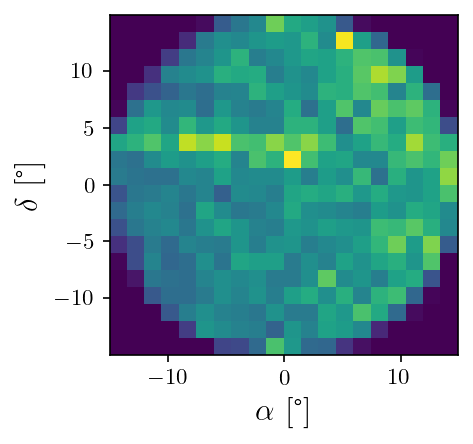

In [94]:
plt.figure(figsize=(3,3),dpi=150)
hist = plt.hist2d(df.α, df.δ, bins=20)
plt.xlabel(r'$\alpha$ [\textdegree]');
plt.ylabel(r'$\delta$ [\textdegree]');

In [95]:
# Get indices for hotspot bin to exclude
i, j = np.unravel_index(hist[0].argmax(), hist[0].shape)

# Exclude this bin based on bin edges 
df2 = df[(df.α < hist[1][i]) | (df.α > hist[1][i+1]) | 
         (df.δ < hist[1][j]) | (df.δ > hist[1][j+1])]

print("{:.1f}% of the dataset remains.".format(100*len(df2)/len(df)))

# Redefine dataframe
df = df2

99.4% of the dataset remains.


### Prepare datasets for training

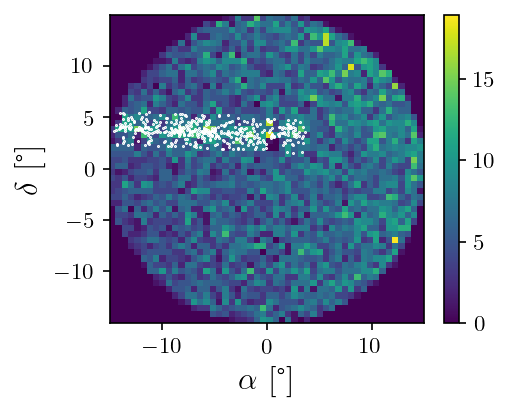

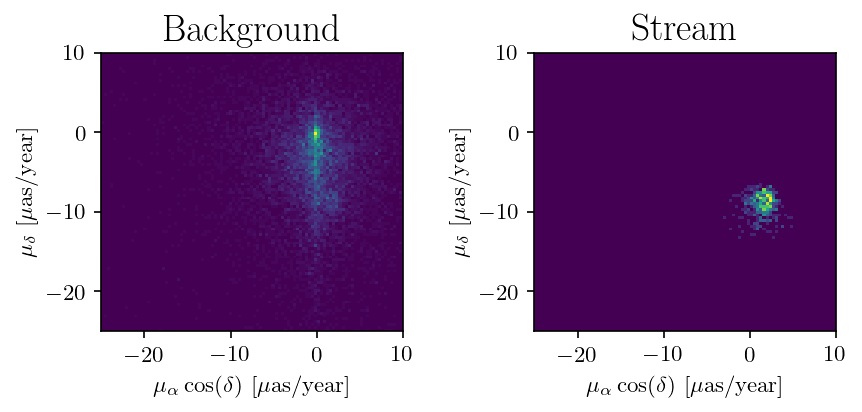

In [96]:
visualize_stream(df, show_stream=True)

Text(0.5, 0, 'GD1 Tail')

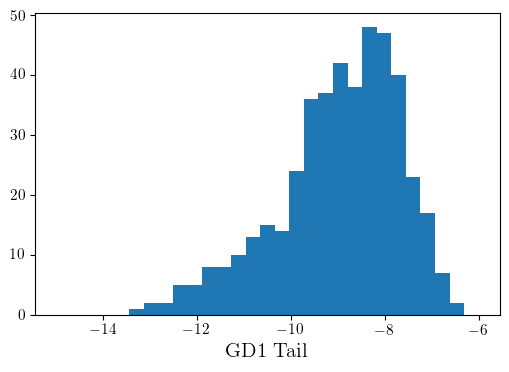

In [97]:
plt.hist(df[df.stream].μ_δ, bins=np.linspace(-15,-6,30));
plt.xlabel('GD1 Tail')

Sideband region: [-15,-5]
Signal region: [-11,-7]
Total counts: SR = 1,928, SB = 2,091
Signal region has 389 stream and 1,539 bkg events (25.28%).
Sideband region has 55 stream and 2,036 bkg events (2.70%).
f_sig = 9.4X f_sideband.


/clusterfs/ml4hep/mpettee/GaiaCWoLa/functions.py:190: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_slice['label'] = np.where(((df_slice.μ_δ > sr_min) & (df_slice.μ_δ < sr_max)), 1, 0)


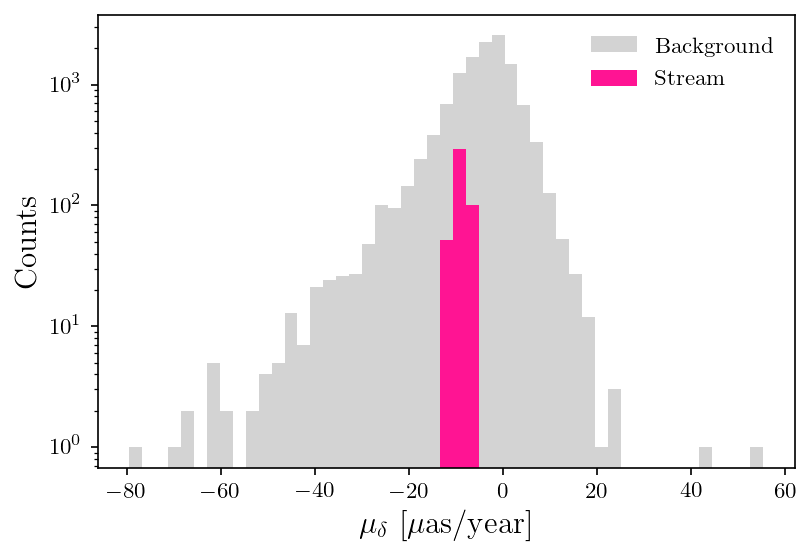

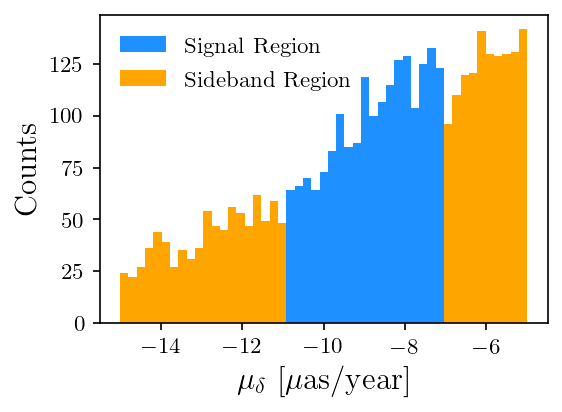

In [98]:
df = signal_sideband(df, stream = stream)

A quick experiment... remove all real stream stars from the sideband region:

In [63]:
# df = df[((df.label == 0) & (df.stream == False)) | (df.label == 1)]

Add sample weights to stream stars:

In [102]:
### Signal region only 
# stream_stars_in_sb = (df['stream'] == True) & (df['label'] == 1)
# df["weight"] = np.where(stream_stars_in_sb, 5, 1)

### Throughout signal & sideband regions
df["weight"] = np.where(df['stream'] == True, 5, 1)

/tmp/ipykernel_19455/56803264.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["weight"] = np.where(df['stream'] == True, 5, 1)


# Train

In [114]:
tf.keras.backend.clear_session()

Using sample weights
Training on 7 events.

Training fold #0...
Model: "sequential_57"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_228 (Dense)            (None, 64)                384       
_________________________________________________________________
dropout_171 (Dropout)        (None, 64)                0         
_________________________________________________________________
dense_229 (Dense)            (None, 64)                4160      
_________________________________________________________________
dropout_172 (Dropout)        (None, 64)                0         
_________________________________________________________________
dense_230 (Dense)            (None, 64)                4160      
_________________________________________________________________
dropout_173 (Dropout)        (None, 64)                0         
_______________________________________________________

/clusterfs/ml4hep/mpettee/miniconda3/envs/gaia/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:990: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  warnings.warn(


AUC: nan
Top 10 stars: Purity = 0.0% 
Top 100 stars: Purity = 0.0% 
Top 0.001% stars: Purity = 0.0% 
Top 0.01% stars: Purity = 0.0% 
Top 0.1% stars: Purity = 0.0% 
Top 1% stars: Purity = 0.0% 
Top 5% stars: Purity = 0.0% 
Top 10% stars: Purity = 0.0% 
Top 20% stars: Purity = 0.0% 


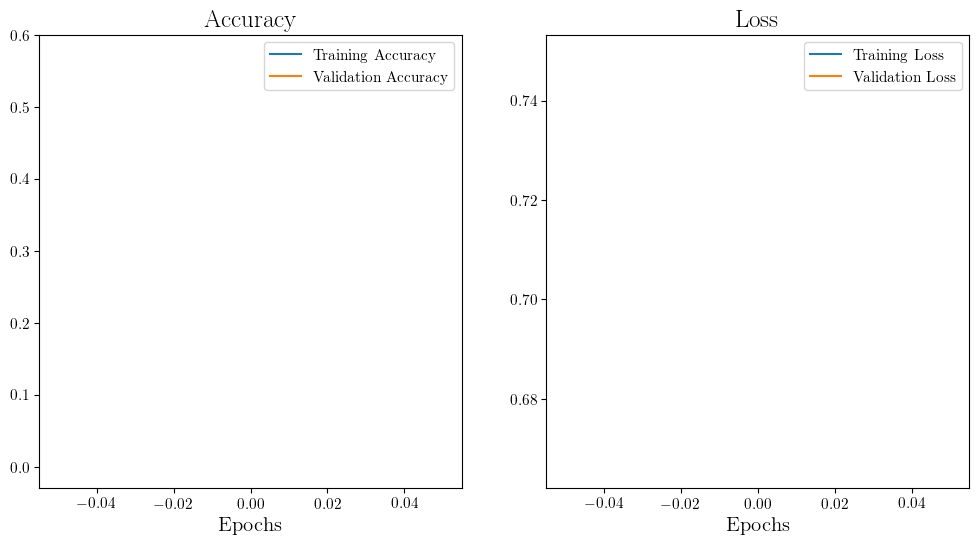

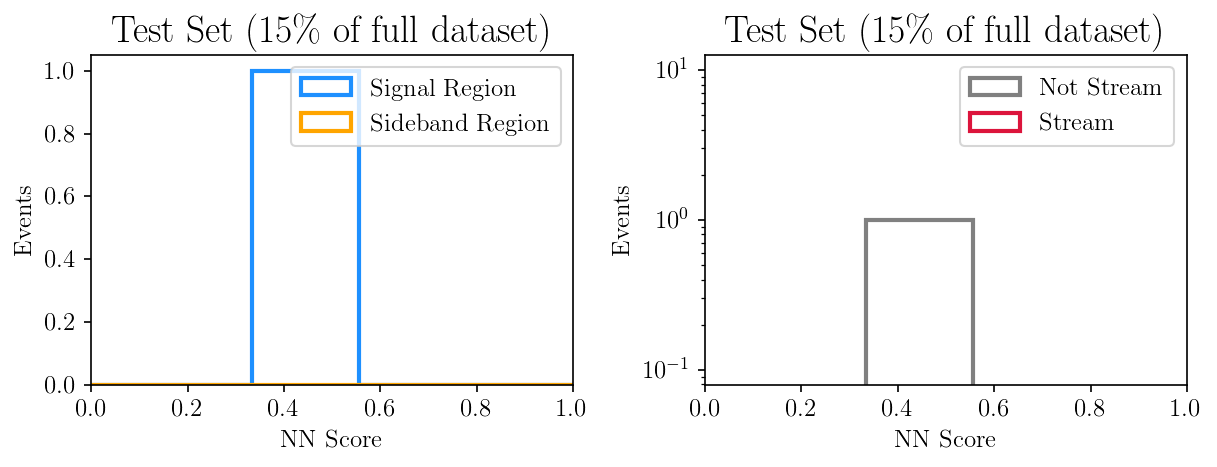

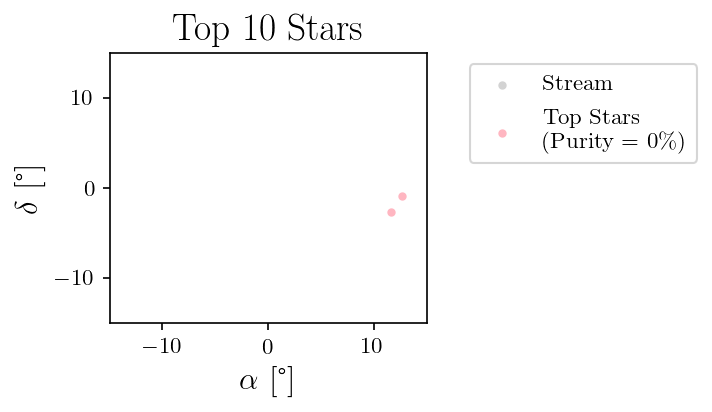

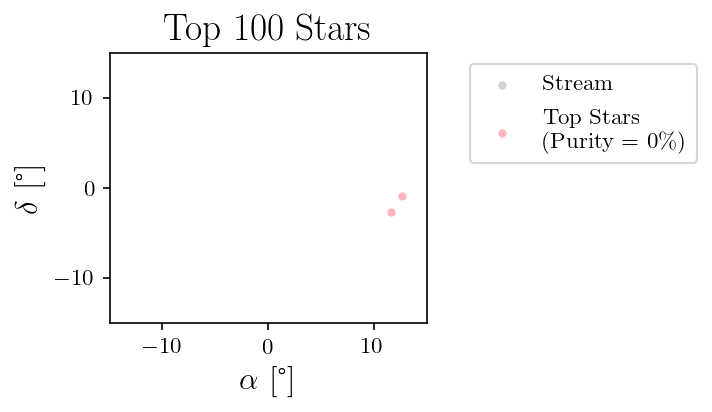

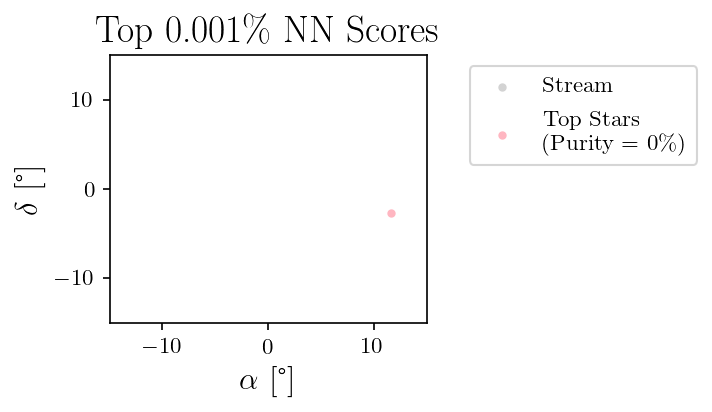

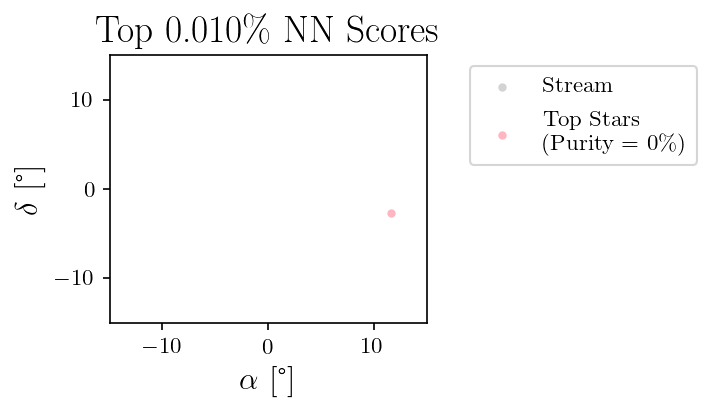

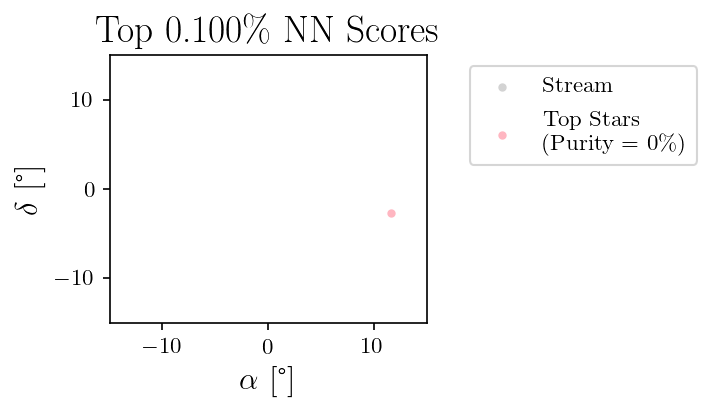

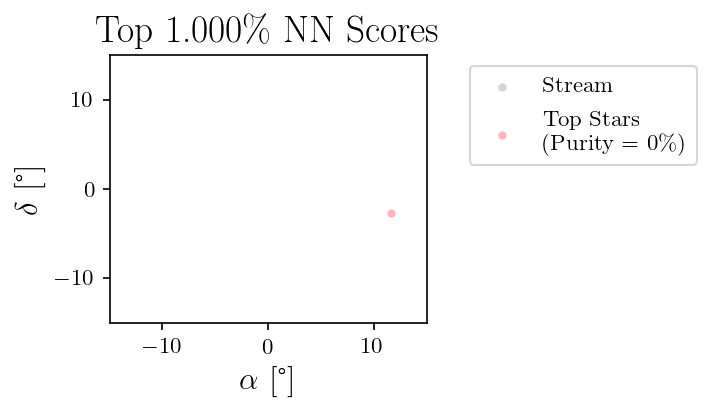

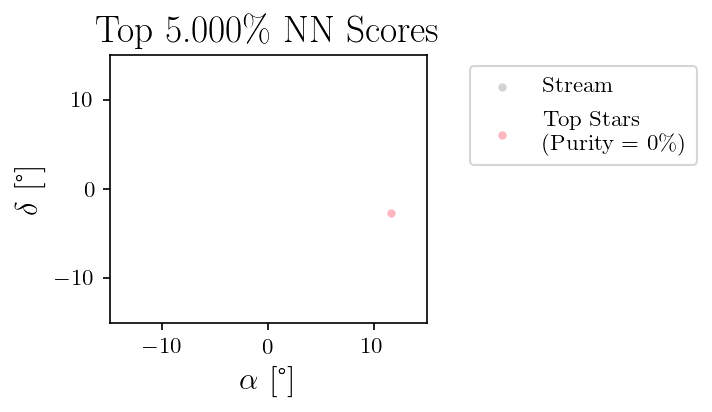

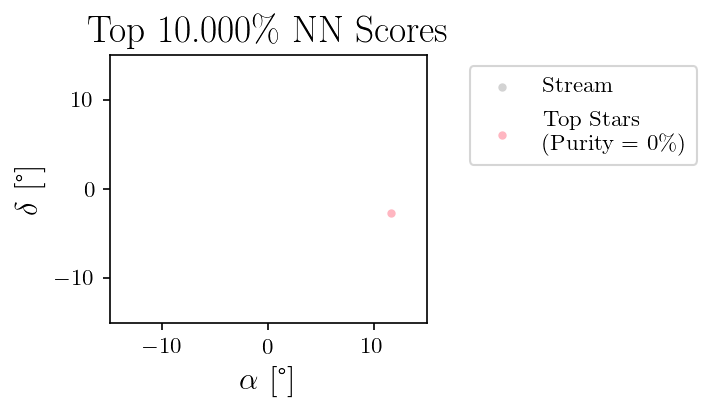

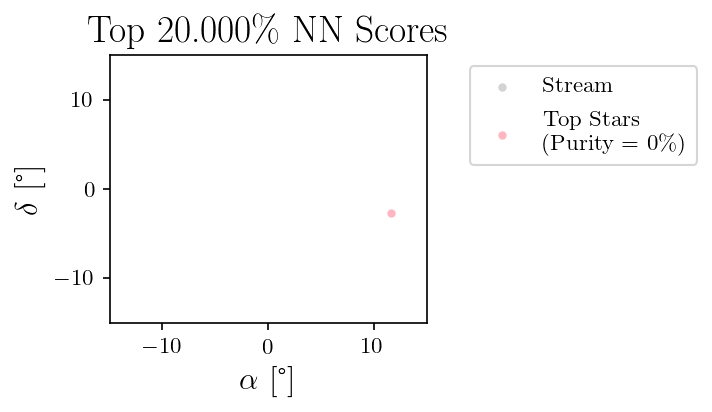

In [121]:
train(df, epochs=200, layer_size=64, dropout=0.2, l2_reg=0, patience=30, 
      n_folds=5, best_of_n_loops=2)
